# EXTRA_SEATS historical offers

In [53]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime

%matplotlib inline


## Read Data

In [2]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']

connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




In [3]:
# should take less than 1 minute
query="""
SELECT * FROM (
        SELECT 
            offer_model.*,
            com_partner.*,
            -- we have no currency after 2019-03-29, so let's pick rate of that date is the offer was made after
            COALESCE(com_currency.inverse_rate,latest_currency.inverse_rate) as offer_usd_currency_inverse_rate,
            -- pick the latest offer for each offer_id (based on the auto id)
            row_number() over (partition by offer_id order by offer_model.auto_id desc NULLS LAST) AS row_number
        FROM offer_model
            LEFT JOIN com_partner on offer_model.carrier = com_partner.partner_code
            LEFT JOIN com_currency on (offer_model.currency = com_currency.currency_code and substring(offer_model.submission_date, 0, 11) = to_char(com_currency.event_time, 'YYYY-MM-DD'))
            LEFT JOIN com_currency latest_currency on (offer_model.currency = latest_currency.currency_code AND to_char(latest_currency.event_time, 'YYYY-MM-DD')= '2019-03-29')
        WHERE upgrade_type IN ('EXTRA_SEAT')
 ) where row_number = 1 ;
"""
raw_df = pd.read_sql_query(query, con)
raw_df.head(3)


auto_id                              event_id  offer_id origin dest  \
0   572838  b4692a6f-ff36-4782-aec1-415e2f81bfea   2226368    ZRH  FAO   
1   589096  67caccde-b131-4f5b-8ccd-109d365e0aef   2270314    TLV  LHR   
2   643415  5109c6f3-00c4-40aa-98ac-62a50fd4ca9d   2271857    HAM  IBZ   

  carrier     pnr  base_offer_amount currency  customer_id     ...      \
0      AB  5G5IBM               65.0      EUR      2339456     ...       
1      LY  6SA5ZM              210.0      USD      2364431     ...       
2      AB  28DF8A               35.0      EUR      2241432     ...       

  slider_starting_amount slider_upper_limit                     status  \
0                   60.0              155.0  UNABLE_TO_TICKET_NO_RETRY   
1                    NaN                NaN                  SUBMITTED   
2                   60.0              155.0                  SUBMITTED   

      submission_date upgrade_type  has_errors  partner_id  partner_code  \
0 2015-10-31 12:47:00   EXTRA_SEAT       False        43.0           AB    
1 2015-11-27 13:37:00   EXTRA_SEAT       False       424.0           LY    
2 2015-11-28 16:58:00   EXTRA_SEAT       False        43.0           AB    

   offer_usd_currency_inverse_rate  row_number  
0                         1.100634           1  
1                         1.000000           1  
2                         1.059416           1  

[3 rows x 46 columns]

# Clean  + amounts in usd

In [4]:
df = raw_df.drop(['row_number','upgrade_type'], axis=1) # we don't need those

# offersamount in usd
df['base_offer_amount_usd'] = df.base_offer_amount * df.offer_usd_currency_inverse_rate
df['offer_amount_usd'] = df.offer_amount * df.offer_usd_currency_inverse_rate
df['offer_amount_total_usd'] = df.offer_amount_total * df.offer_usd_currency_inverse_rate

# sliders amount in usd
df['slider_lower_limit_usd'] = df.slider_lower_limit * df.offer_usd_currency_inverse_rate
df['slider_starting_amount_usd'] = df.slider_starting_amount * df.offer_usd_currency_inverse_rate
df['slider_upper_limit_usd'] = df.slider_upper_limit * df.offer_usd_currency_inverse_rate

In [5]:
df.head(3)

auto_id                              event_id  offer_id origin dest  \
0   572838  b4692a6f-ff36-4782-aec1-415e2f81bfea   2226368    ZRH  FAO   
1   589096  67caccde-b131-4f5b-8ccd-109d365e0aef   2270314    TLV  LHR   
2   643415  5109c6f3-00c4-40aa-98ac-62a50fd4ca9d   2271857    HAM  IBZ   

  carrier     pnr  base_offer_amount currency  customer_id  \
0      AB  5G5IBM               65.0      EUR      2339456   
1      LY  6SA5ZM              210.0      USD      2364431   
2      AB  28DF8A               35.0      EUR      2241432   

            ...           has_errors partner_id partner_code  \
0           ...                False       43.0          AB    
1           ...                False      424.0          LY    
2           ...                False       43.0          AB    

   offer_usd_currency_inverse_rate base_offer_amount_usd  offer_amount_usd  \
0                         1.100634             71.541229         71.541229   
1                         1.000000            210.000000        210.000000   
2                         1.059416             37.079571         37.079571   

   offer_amount_total_usd  slider_lower_limit_usd  slider_starting_amount_usd  \
0               71.541229               38.522200                   66.038058   
1              210.000000                     NaN                         NaN   
2               37.079571               37.079571                   63.564978   

   slider_upper_limit_usd  
0              170.598316  
1                     NaN  
2              164.209527  

[3 rows x 50 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94209 entries, 0 to 94208
Data columns (total 50 columns):
auto_id                             94209 non-null int64
event_id                            94209 non-null object
offer_id                            94209 non-null int64
origin                              94209 non-null object
dest                                94209 non-null object
carrier                             94209 non-null object
pnr                                 94209 non-null object
base_offer_amount                   94209 non-null float64
currency                            94209 non-null object
customer_id                         94209 non-null int64
locale                              94209 non-null object
departure_time                      94209 non-null datetime64[ns]
departure_time_server               94209 non-null datetime64[ns]
duration                            94209 non-null int64
fare_class                          94209 non-null object
flight_n

In [7]:
#What is the distribution of numerical feature values across the samples?
df.describe()

auto_id      offer_id  base_offer_amount   customer_id  \
count  9.420900e+04  9.420900e+04       9.420900e+04  9.420900e+04   
mean   7.257149e+06  6.703795e+06       5.550332e+02  4.840557e+06   
std    4.622235e+06  2.594369e+06       6.444354e+03  1.622131e+06   
min    7.300000e+01  2.226368e+06       5.000000e+00  1.736665e+06   
25%    3.232861e+06  4.527877e+06       5.500000e+01  3.567023e+06   
50%    6.618315e+06  6.271360e+06       1.200000e+02  4.515082e+06   
75%    1.123403e+07  8.806458e+06       2.390000e+02  6.036605e+06   
max    1.624531e+07  1.192788e+07       1.428980e+06  8.302763e+06   

           duration  flight_number  offer_amount  offer_amount_total  \
count  94209.000000   94209.000000  9.420900e+04        9.420900e+04   
mean     484.796569    1226.848942  5.607135e+02        7.398883e+02   
std      262.001969    2383.570843  6.451970e+03        1.111821e+04   
min        0.000000       1.000000  5.000000e+00        5.000000e+00   
25%      285.000000      42.000000  5.500000e+01        6.000000e+01   
50%      440.000000     303.000000  1.200000e+02        1.500000e+02   
75%      770.000000     484.000000  2.390000e+02        3.000000e+02   
max     1020.000000    8990.000000  1.428980e+06        2.857960e+06   

       offer_expiration_minutes  offer_modification_cutoff_hours  \
count              94209.000000                     94209.000000   
mean               -1002.881784                        21.982125   
std                  988.864604                        21.175308   
min               -14400.000000                         0.000000   
25%                -1740.000000                         4.000000   
50%                -1080.000000                        20.000000   
75%                 -210.000000                        34.000000   
max                  -60.000000                        76.000000   

                ...            slider_starting_amount  slider_upper_limit  \
count           ...                      8.582300e+04        8.582300e+04   
mean            ...                      6.992225e+02        1.646027e+03   
std             ...                      6.867032e+03        1.573875e+04   
min             ...                      1.000000e+01        2.000000e+01   
25%             ...                      6.500000e+01        1.400000e+02   
50%             ...                      1.300000e+02        2.900000e+02   
75%             ...                      2.400000e+02        5.550000e+02   
max             ...                      1.214635e+06        2.857960e+06   

         partner_id  offer_usd_currency_inverse_rate  base_offer_amount_usd  \
count  91966.000000                     94209.000000           9.420900e+04   
mean      69.512429                         0.843779           1.192249e+02   
std      144.384947                         0.433115           4.655920e+03   
min       11.000000                         0.000000           0.000000e+00   
25%       11.000000                         0.272273           5.581427e+01   
50%       11.000000                         1.000000           7.796562e+01   
75%       43.000000                         1.122118           1.252483e+02   
max      606.000000                         3.341375           1.428980e+06   

       offer_amount_usd  offer_amount_total_usd  slider_lower_limit_usd  \
count      9.420900e+04            9.420900e+04            8.582300e+04   
mean       1.194640e+02            1.614317e+02            1.169649e+02   
std        4.655921e+03            9.311485e+03            7.316682e+03   
min        0.000000e+00            0.000000e+00            0.000000e+00   
25%        5.587880e+01            5.907233e+01            4.713402e+01   
50%        7.796562e+01            1.007357e+02            6.567247e+01   
75%        1.257120e+02            1.679956e+02            1.177625e+02   
max        1.428980e+06            2.857960e+06            2.143470e+06   

       slider_starting_amount_usd  sl

In [8]:
#What is the distribution of categorical feature values across the samples?
df.describe(include = ["O"])

event_id origin   dest carrier     pnr  \
count                                  94209  94209  94209   94209   94209   
unique                                 83176    192    215       8   61012   
top     f737246e-4afd-4d56-b89c-3b5d6e12e502    AUH    AUH      EY  K2I8T5   
freq                                      13  39075  28676   67661      18   

       currency locale fare_class point_of_sale  \
count     94209  94209      94209         94209   
unique       30     29         22            85   
top         EUR     en          U            AE   
freq      25810  61377      19571         31673   

                                request_id     status partner_code  
count                                94209      94209        91966  
unique                               65745         13            7  
top     BDTrEnQ5SjKGL7bn2RtGa0EcODS5SV3V3o  SUBMITTED          EY   
freq                                    18      55551        67661

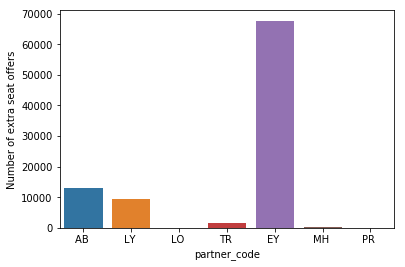

In [15]:
sns.countplot(df.partner_code);
plt.xlabel('partner_code');
plt.ylabel('Number of extra seat offers');
plt.show()


In [92]:
df.head(3)

auto_id                              event_id  offer_id origin dest  \
0   572838  b4692a6f-ff36-4782-aec1-415e2f81bfea   2226368    ZRH  FAO   
1   589096  67caccde-b131-4f5b-8ccd-109d365e0aef   2270314    TLV  LHR   
2   643415  5109c6f3-00c4-40aa-98ac-62a50fd4ca9d   2271857    HAM  IBZ   

  carrier     pnr  base_offer_amount currency  customer_id  \
0      AB  5G5IBM               65.0      EUR      2339456   
1      LY  6SA5ZM              210.0      USD      2364431   
2      AB  28DF8A               35.0      EUR      2241432   

            ...           has_errors partner_id partner_code  \
0           ...                False       43.0          AB    
1           ...                False      424.0          LY    
2           ...                False       43.0          AB    

   offer_usd_currency_inverse_rate base_offer_amount_usd  offer_amount_usd  \
0                         1.100634             71.541229         71.541229   
1                         1.000000            210.000000        210.000000   
2                         1.059416             37.079571         37.079571   

   offer_amount_total_usd  slider_lower_limit_usd  slider_starting_amount_usd  \
0               71.541229               38.522200                   66.038058   
1              210.000000                     NaN                         NaN   
2               37.079571               37.079571                   63.564978   

   slider_upper_limit_usd  
0              170.598316  
1                     NaN  
2              164.209527  

[3 rows x 50 columns]

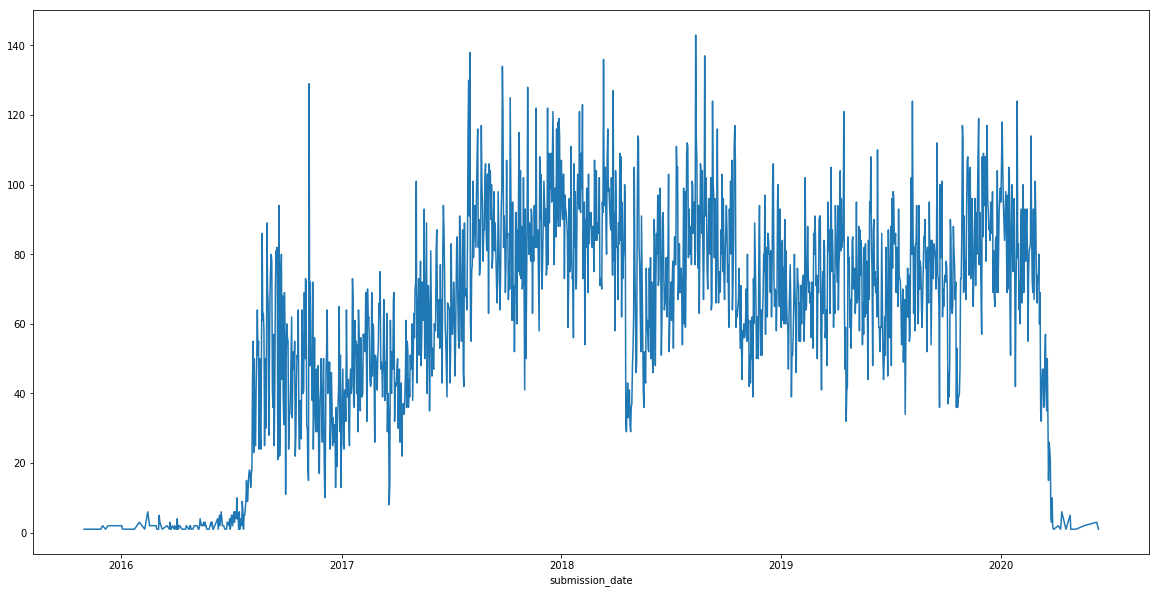

In [93]:
df.groupby(by=[df.submission_date.dt.date]).size().plot(figsize=(20,10))

In [94]:
df_filter = df[df.submission_date>datetime(2020,1,1)]
timeseries = df_filter.groupby(by=[df_filter.submission_date.dt.date,df_filter.carrier])

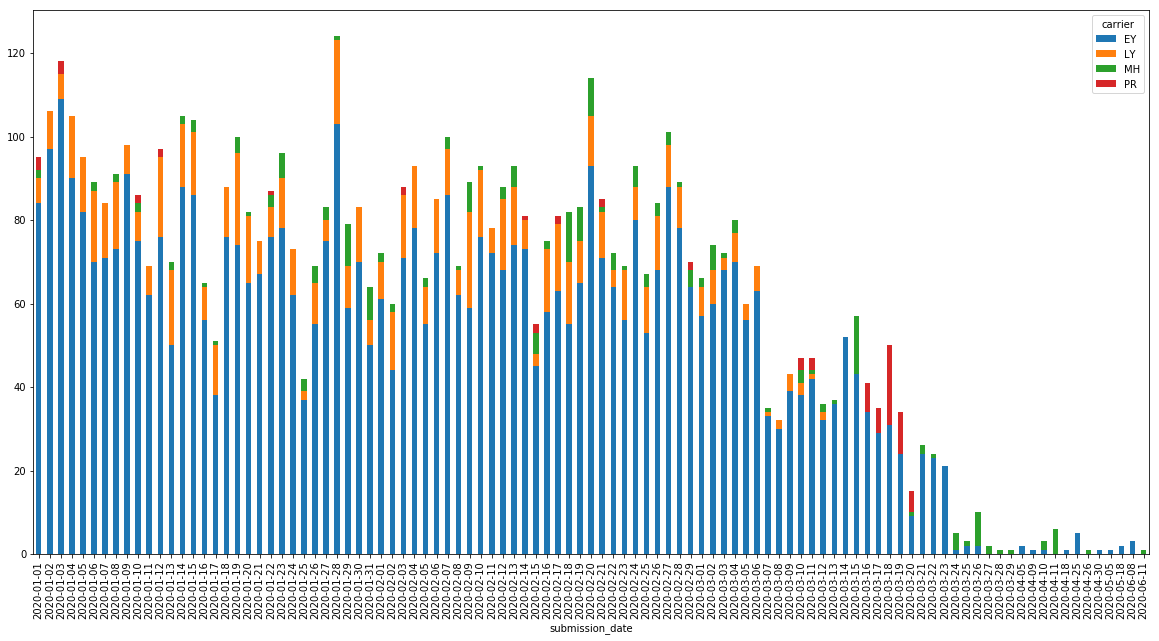

In [95]:
timeseries.size().unstack('carrier').plot.bar(figsize=(20,10),stacked=True)